In [33]:
#!/usr/bin/python
# -*- coding: latin-1 -*-
"""This notebook creates the statistics of TAG in Spain in YEAR"""

import inspect, os, sys

try :
    import pywikibot as pb
    from pywikibot import pagegenerators, textlib
    from pywikibot.specialbots import UploadRobot

except :
    current_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile(inspect.currentframe()))[0]))
    folder_parts = current_folder.split(os.sep)
    pywikibot_folder = os.sep.join(folder_parts[:-1])

    if current_folder not in sys.path:
        sys.path.insert(0, current_folder)
    if pywikibot_folder not in sys.path:
        sys.path.insert(0, pywikibot_folder)

    import pywikibot as pb
    from pywikibot import pagegenerators, textlib
    from pywikibot.specialbots import UploadRobot

import mwparserfromhell as mwh

from modules.wmtools import upload_to_commons, get_registration_time, heat_color, get_project_name, wrap_label

In [34]:
import pandas as pd
import numpy as np
from mako.template import Template
from io import StringIO, BytesIO
from datetime import datetime, timedelta
from urllib.parse import urlencode
import requests
import json
from itertools import groupby
from operator import itemgetter
from functools import reduce
import math
import random

In [35]:
from geojson import Feature, Point, FeatureCollection
import geojson

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns

sns.set_style("darkgrid")
%matplotlib inline

In [37]:
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans',
                                  'Bitstream Vera Sans',
                                  'Computer Modern Sans Serif',
                                  'Lucida Grande',
                                  'Verdana',
                                  'Geneva',
                                  'Lucid',
                                  'Arial',
                                  'Helvetica',
                                  'Avant Garde',
                                  'sans-serif']

In [66]:
import matplotlib.font_manager
matplotlib.font_manager.findfont(matplotlib.font_manager.FontProperties())

'/srv/paws/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [38]:
YEAR                = 2017
TAG                 = 'WLF'
TAG_EXT             = 'Wiki Loves Folk'

BASE_WLF_NAME       = 'Commons:{1}/{0}'.format(YEAR, TAG_EXT)
BASE_WLF2016_NAME   = 'Commons:{1}/{0}'.format(2016, TAG_EXT)
LOG_PAGE            = BASE_WLF_NAME + '/Log'
STATISTICS_PAGE     = BASE_WLF_NAME + '/Stats'
FESTIVAL_DB_PAGE    = BASE_WLF2016_NAME + '/Festival DB'
GALLERY_QI          = BASE_WLF_NAME + '/QI'

VALID_NAMESPACES    = ['0', '4', '100', '104']
DAYS_BEFORE_REGISTRATION = 15

WLF_FINALIST_CATEGORY = "Category:Images from {1} {0} in Spain (finalists)".format(YEAR, TAG_EXT)

commons_site = pb.Site('commons', 'commons')

In [39]:
MW_API_BASE_URL     = 'https://commons.wikimedia.org/w/api.php'
MW_API_QUERY_STRING = {"action": "query",
                       "format": "json",
                       "gulimit": "500",
                       "prop": "globalusage",
                       "guprop": "url|namespace",
                       "titles": None
                      }

In [40]:
figsize=[15., 10.]
figsize_half=[8., 10.]
figsize_high=[15., 30.]
figsize_low=[15., 6.]

In [41]:
shake_step=0.01

In [42]:
cwd = os.getcwd()

images_directory = os.path.join(cwd, 'images')
if not os.path.exists(images_directory):
    os.makedirs(images_directory)
    
templates_directory = os.path.join(cwd, 'templates')

In [43]:
now = (datetime.now().strftime("%Y-%m-%d"))

In [44]:
def get_campaign (row):
    """Function that classifies images according to uploade date.
    THIS IS A YEAR-DEPENDENT FUNCTION"""
    start_datetime_fallas = datetime(YEAR, 3, 1)
    end_datetime_fallas   = datetime(YEAR, 5, 1) + timedelta(hours=2)
    start_datetime_summer = datetime(YEAR, 6, 21)
    end_datetime_summer   = datetime(YEAR, 9, 21) + timedelta(hours=2)
    start_datetime_autumm = datetime(YEAR, 11, 1)
    end_datetime_autumm   = datetime(YEAR, 12, 1) + timedelta(hours=2)
    
    if (row['timestamp'] > start_datetime_fallas) and (row['timestamp'] < end_datetime_fallas):
        return "fallas"
    elif (row['timestamp'] > start_datetime_summer) and (row['timestamp'] < end_datetime_summer):
        return "summer"
    elif (row['timestamp'] > start_datetime_autumm) and (row['timestamp'] < end_datetime_autumm):
        return "autumn"
    else :
        return ""

In [45]:
def expand_itemid (_list):
    new_list = [{"itemid": i, "category": festivals_df[festivals_df['wikidata_id'] == i]['category'].values[0]} for i in _list]
    if len(new_list) > 0:
        new_list = sorted(new_list, key=lambda k: k['category']) 
    return new_list

def decode_list (_list) :
    try:
        new_list = _list[:]
    except :
        new_list = []
    return new_list

In [46]:
def shaker (row) :
    coordinates = (row['latitude'], row['longitude'])
    if row['dup'] == True:
        random.seed(len(row['category']))
        term_selector = random.randint(0,1)
        sign_selector = -1
        if random.random() < 0.5 :
            sign_selector = 1
        shake = [0.0] * 2
        shake[term_selector] = sign_selector*shake_step
        shake = set(shake)
        coordinates = tuple(x + y for x, y in zip(shake, coordinates))

    return coordinates

In [47]:
def to_geojson (row) :
    reduced_images_df = images_df[images_df['wikidata_id'] == row['wikidata_id']]
    if len(reduced_images_df[reduced_images_df['qi'] == 'qi']) > 0 :
        image = reduced_images_df[reduced_images_df['qi'] == 'qi'].sample(1, random_state=0)['image_title'].values[0]
    elif len(reduced_images_df[reduced_images_df['finalist'] == 'finalist']) > 0 :
        image = reduced_images_df[reduced_images_df['finalist'] == 'finalist'].sample(1, random_state=0)['image_title'].values[0]
    else :
        image = reduced_images_df.sample(1, random_state=0)['image_title'].values[0]

    feature = Feature(geometry=Point((row['longitude'], row['latitude'])), 
                      properties={"description": "[[File:{0}|150px]]".format(image),
                                  "title": "[[:Category:Images of festival with code {0} from {2} {1} in Spain|{3}]]".format(row['wikidata_id'], YEAR, TAG_EXT, row['category']),
                                  "marker-size": "small",
                                  "marker-symbol": "circle",
                                  "marker-color": autcom_colors[row['aut_com']]}
                     )
    return feature

In [48]:
# Image description
plot_description = """== {{{{int:filedesc}}}} ==
{{{{Information
|description={{{{en|{2}}}}}
|source={{{{own}}}}
|author=[[User:Discasto|Discasto]]
|date={3}
}}}}

{{{{Created with Matplotlib}}}}

== {{{{int:license-header}}}} ==
{{{{self|cc-by-sa-4.0}}}}

[[Category:Photos by User:Discasto]]
[[Category:{0} {1} in Spain]]"""

In [49]:
festival_annexes = [
    ['Anexo:Fiestas de interés turístico de Andalucía', 'Andalusia'],
    ['Anexo:Fiestas de interés turístico de Aragón', 'Aragon'],
    ['Anexo:Fiestas de interés turístico de Asturias', 'Asturias'],
    ['Anexo:Fiestas de interés turístico de Cantabria', 'Cantabria'],
    ['Anexo:Fiestas de interés turístico de Castilla-La Mancha', 'Castile-La Mancha'],
    ['Anexo:Fiestas de interés turístico de Castilla y León', 'Castile and León'],
    ['Anexo:Fiestas de interés turístico de Cataluña', 'Catalonia'],
    ['Anexo:Fiestas de interés turístico de la Comunidad de Madrid', 'Community of Madrid'],
    ['Anexo:Fiestas de interés turístico de la Comunidad Valenciana', 'Valencian Community'],
    ['Anexo:Fiestas de interés turístico de Extremadura', 'Extremadura'],
    ['Anexo:Fiestas de interés turístico de las Islas Baleares', 'Balearic Islands'],
    ['Anexo:Fiestas de interés turístico de las Islas Canarias', 'Canary Islands'],
    ['Anexo:Fiestas de interés turístico de Galicia', 'Galicia'],
    ['Anexo:Fiestas de interés turístico de La Rioja', 'La Rioja'],
    ['Anexo:Fiestas de interés turístico de Navarra', 'Navarre'],
    ['Anexo:Fiestas de interés turístico de la Región de Murcia', 'Region of Murcia'],
    ['Anexo:Fiestas y tradiciones del País Vasco', 'Basque Country']
]
annexes = pd.DataFrame(data=festival_annexes, columns=['annex', 'aut_com']).set_index(['aut_com'])['annex']

annexes

aut_com
Andalusia                Anexo:Fiestas de interés turístico de Andalucía
Aragon                      Anexo:Fiestas de interés turístico de Aragón
Asturias                  Anexo:Fiestas de interés turístico de Asturias
Cantabria                Anexo:Fiestas de interés turístico de Cantabria
Castile-La Mancha      Anexo:Fiestas de interés turístico de Castilla...
Castile and León       Anexo:Fiestas de interés turístico de Castilla...
Catalonia                 Anexo:Fiestas de interés turístico de Cataluña
Community of Madrid    Anexo:Fiestas de interés turístico de la Comun...
Valencian Community    Anexo:Fiestas de interés turístico de la Comun...
Extremadura            Anexo:Fiestas de interés turístico de Extremadura
Balearic Islands       Anexo:Fiestas de interés turístico de las Isla...
Canary Islands         Anexo:Fiestas de interés turístico de las Isla...
Galicia                    Anexo:Fiestas de interés turístico de Galicia
La Rioja                  Anexo:Fiestas de 

In [50]:
autcom_palette = [i[1:] for i in sns.color_palette('hls', 17).as_hex()]
autcoms = [i[1] for i in festival_annexes]
autcom_colors = {autcom: autcom_palette[i] for i, autcom in enumerate(autcoms)}
autcom_colors

{'Andalusia': 'db5f57',
 'Aragon': 'db8d57',
 'Asturias': 'dbbc57',
 'Balearic Islands': '578ddb',
 'Basque Country': 'db577e',
 'Canary Islands': '575edb',
 'Cantabria': 'ccdb57',
 'Castile and León': '6edb57',
 'Castile-La Mancha': '9ddb57',
 'Catalonia': '57db6e',
 'Community of Madrid': '57db9d',
 'Extremadura': '57bcdb',
 'Galicia': '7e57db',
 'La Rioja': 'ad57db',
 'Navarre': 'db57db',
 'Region of Murcia': 'db57ac',
 'Valencian Community': '57dbcc'}

In [51]:
pb.output('Retrieving --> {0} in Spain Festivals list from cache'.format(TAG))
festival_list_page = pb.Page(commons_site, FESTIVAL_DB_PAGE)
festival_list_text = StringIO(festival_list_page.text[festival_list_page.text.find('\n') + 1:festival_list_page.text.rfind('\n')])
festivals_df = pd.read_csv(festival_list_text, 
                           sep=";", 
                           index_col=False, 
                           names=['name', 'aut_com', 
                                  'wikidata_id', 'wikidata_timestamp', 
                                  'category', 'cat_timestamp', 'image',
                                  'latitude', 'longitude']
                          )
pb.output('Retrieved --> {0} in Spain Festivals list from cache'.format(TAG))

Retrieving --> WLF in Spain Festivals list from cache
Retrieved --> WLF in Spain Festivals list from cache


In [52]:
festivals_df.head()

,name,aut_com,wikidata_id,wikidata_timestamp,category,cat_timestamp,image,latitude,longitude
0,Carnaval de Cádiz,Andalusia,Q2939698,1.358030e+12,Carnival of Cádiz,1.172166e+12,Carnavaldecadiz.jpg,36.516667,-6.283333
1,Semana Santa en Málaga,Andalusia,Q9075883,1.364769e+12,Holy Week in Málaga,1.262418e+12,"Cristo de La Humillacion y Perdón, Lateral izq...",36.716667,-4.416667
2,Semana Santa de Sevilla,Andalusia,Q1469338,1.356186e+12,Holy Week in Seville,1.270393e+12,Macarena Sevilla-detail.jpg,37.383333,-5.983333
3,Semana Santa en Granada,Andalusia,Q9075873,1.364769e+12,Holy Week in Granada,1.239229e+12,Venerable Hermandad del Santísimo Cristo de la...,37.178056,-3.600833
4,Feria de Abril,Andalusia,Q2918983,1.357986e+12,Feria de Abril,1.148114e+12,Séville-Féria de Abril-1028-1992 05 06.jpg,37.383333,-5.983333


In [53]:
festival_length = len(festivals_df.index)
festival_length

1238

In [54]:
valid_festivals = festivals_df['wikidata_id'].values
valid_festivals

array(['Q2939698', 'Q9075883', 'Q1469338', ..., 'Q23655957', 'Q23655971',
       'Q23655987'], dtype=object)

In [55]:
pb.output('Retrieving --> {1} {0} in Spain images list from cache'.format(YEAR, TAG))
list_page = pb.Page(commons_site, LOG_PAGE)
list_page_text = StringIO(list_page.text[list_page.text.find('\n') + 1:list_page.text.rfind('\n')])
images_df = pd.read_csv(list_page_text,
                            sep=";",
                            index_col=False,
                            names=['image_title', 'wikidata_id', 'uploader', 'time_to_upload', 'timestamp', 'qi', 'finalist']
                       ).fillna('')
pb.output('Retrieved --> {1} {0} in Spain images list from cache'.format(YEAR, TAG))

images_df['timestamp'] = pd.to_datetime(images_df['timestamp'], format="%Y-%m-%d %H:%M:%S")
images_df['campaign'] = images_df.apply (lambda row: get_campaign(row), axis=1)

images_df.set_index(["timestamp"], inplace=True)
del images_df.index.name

total_images_length = len(images_df)
total_images_length

Retrieving --> WLF 2017 in Spain images list from cache
Retrieved --> WLF 2017 in Spain images list from cache


2541

In [56]:
qi_list = images_df[images_df['qi'] == 'qi']['image_title']
qi_list

2017-09-10 09:49:28              Algemesí MDS - Recaudando Donativos.jpg
2017-04-01 01:15:37                       Fallas2015 04 Entrada Mora.jpg
2017-04-01 00:49:19    Fallas2017 05 Convento Jerusalen Matematico Ma...
2017-04-01 19:56:24                      Fallas2017 18 Museo Fallero.jpg
2017-04-01 10:18:52              Fallas2017 20 Sueca Literato Azorin.jpg
2017-04-01 23:41:27                           Fallas2017 Mascletà 03.jpg
2017-04-01 23:41:34                           Fallas2017 Mascletà 06.jpg
2017-04-01 20:16:07                             Fallas2017 Ofrena 15.jpg
2017-07-04 16:28:57              Gran Fira Valencia 2016 Correfoc 04.jpg
Name: image_title, dtype: object

In [57]:
qi_length = len(qi_list)
qi_length

9

In [58]:
# THIS IS YEAR-DEPENDENT
campaign_count = images_df['campaign'].value_counts()
campaign_count = campaign_count.reindex(['fallas', 'summer', 'autumn'])
campaign_count

fallas     657
summer      75
autumn    1809
Name: campaign, dtype: int64

[[commons:File:WLF 2017 in Spain - Contributions by campaign.png]]


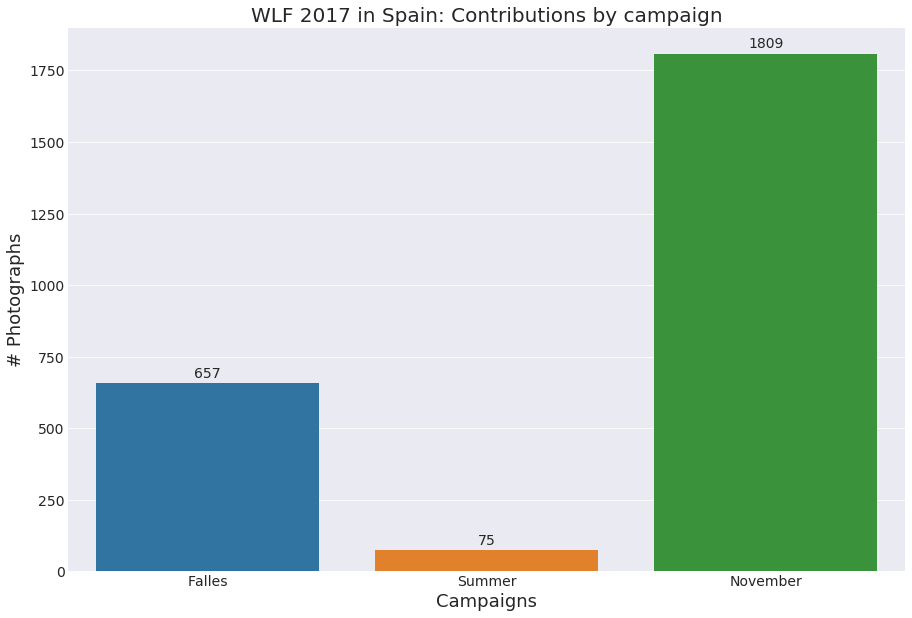

In [59]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x=campaign_count.index, y=campaign_count.values)
p.set_xlabel("Campaigns", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Contributions by campaign'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(['Falles', 'Summer', 'November'])

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 20,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=14)
    
upload_to_commons(p,
                  "{1} {0} in Spain - Contributions by campaign.png".format(YEAR, TAG),
                  '{1} {0} in Spain: Contributions by campaign'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [32]:
uploaders = images_df.groupby(['uploader']).min()['time_to_upload']
uploaders

uploader
19Tarrestnom65                             1160
ASOCIACIÓN DE VECINOS "VIRGEN CORONADA"       0
Andrelopesnunes2                              0
Annadctu                                      0
Antonia Marcelo Garcia                        0
Balablanca                                    0
Bgasco                                      444
Calvesklein                                   0
Coentor                                    3298
Daviibecerril                                 0
Dbascones                                   930
Distritofallas                                0
Dorieo                                     3168
EdurNeapoli                                   0
Egilqui                                       0
El Pantera                                 3872
Encar.sp                                      0
Enric                                       710
EnricRodri                                    0
Ernest Alagarda                               0
FallaTioPep                    

In [ ]:
time_to_upload = uploaders.value_counts().sort_index(ascending=False)
time_to_upload

In [ ]:
age = pd.cut(uploaders, bins=[0, 15, 365, 730, 3650, 5000], include_lowest=True).value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, y=age.index, x=age.values)
p.set_xlabel("# Contestants", fontsize=18)
p.set_ylabel("Age (time from registration)", fontsize=18)

p.set_title(label='{1} {0} in Spain: Contestant age'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_yticklabels(['Less than 15 days\nnew )', 
                   'Between 15 days\nand one year', 
                   'Between one\nand two years', 
                   'Between two\nand ten years', 
                   'More than ten years'])

for patch in ax.patches:
    ax.text(patch.get_width() + 1,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

upload_to_commons(p,
                  "{1} {0} in Spain - Contestant age.png".format(YEAR, TAG),
                  '{1} {0} in Spain: Contestant age. Time from registration to first contribution to contest.'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
authors_length = len(uploaders.index)
authors_length

In [ ]:
images_per_uploader = images_df['uploader'].value_counts()
images_per_uploader = images_per_uploader.rename('images')
images_per_uploader

In [ ]:
# New uploaders
days_before_registration = DAYS_BEFORE_REGISTRATION
new_uploaders = uploaders[uploaders<days_before_registration].index
new_uploaders

In [ ]:
new_uploaders_length = len(new_uploaders)
new_uploaders_length

In [ ]:
new_uploaders = images_per_uploader[new_uploaders]
new_uploaders

In [ ]:
images_per_uploader = images_df['uploader'].value_counts()
images_per_uploader = images_per_uploader.rename('images')
images_per_uploader = images_per_uploader.iloc[np.lexsort([images_per_uploader.index, -images_per_uploader.values])]
images_per_uploader

In [ ]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
TOP_UPLOADERS = 13

In [ ]:
images_per_uploader.size

In [ ]:
remaining_images_per_uploader_count = images_per_uploader[TOP_UPLOADERS:].count()
remaining_images_per_uploader_count

In [ ]:
remaining_images_per_uploader_sum = images_per_uploader[TOP_UPLOADERS:].sum()
remaining_images_per_uploader_sum

In [ ]:
remaining_images_per_uploader = images_per_uploader[:TOP_UPLOADERS]
remaining_images_per_uploader = remaining_images_per_uploader.iloc[np.lexsort([remaining_images_per_uploader.index, -remaining_images_per_uploader.values])]
remaining_images_per_uploader = remaining_images_per_uploader.append(pd.Series(data={"Rest ({0})".format(remaining_images_per_uploader_count): remaining_images_per_uploader_sum}))
remaining_images_per_uploader

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x=remaining_images_per_uploader.index, y=remaining_images_per_uploader.values)
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Top uploaders'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 10,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors.png".format(YEAR, TAG),
                  'Top {2} contributors to {1} {0} in Spain'.format(YEAR, TAG_EXT, TOP_UPLOADERS),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
images_df['uploader'].unique()

In [ ]:
images_df['uploader'].unique().size

In [ ]:
valid_images_length = len(images_df[images_df['wikidata_id'].isin(valid_festivals)].index)
valid_images_length

In [ ]:
images_df[images_df['wikidata_id'].isin(valid_festivals)]['wikidata_id'].unique()

In [ ]:
festivals_per_uploader_df = images_df[images_df['wikidata_id'].isin(valid_festivals)].\
                                    groupby(['uploader']).\
                                    agg({"wikidata_id": pd.Series.nunique}).\
                                    sort_values('wikidata_id', ascending=False)
festivals_per_uploader = festivals_per_uploader_df["wikidata_id"]
festivals_per_uploader = festivals_per_uploader.rename('festivals')
festivals_per_uploader = festivals_per_uploader.iloc[np.lexsort([festivals_per_uploader.index, -festivals_per_uploader.values])]
festivals_per_uploader

In [ ]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
TOP_UPLOADERS_BY_FESTIVAL = 14

In [ ]:
images_df[images_df['wikidata_id'].isin(valid_festivals)]['wikidata_id'].unique()

In [ ]:
wlf_festivals_length = images_df[images_df['wikidata_id'].isin(valid_festivals)]['wikidata_id'].unique().size
wlf_festivals_length

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, 
                x=festivals_per_uploader[:TOP_UPLOADERS_BY_FESTIVAL].index, 
                y=festivals_per_uploader[:TOP_UPLOADERS_BY_FESTIVAL].values
               )
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Festivals", fontsize=18)

p.set_title(label='{1} {0} in Spain: Top uploaders by festival'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)
p.yaxis.set_major_locator(MaxNLocator(integer=True))

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 0.1,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors by festival.png".format(YEAR, TAG),
                  'Top {2} contributors to {1} {0} in Spain'.format(YEAR, TAG_EXT, TOP_UPLOADERS_BY_FESTIVAL),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
uploaders_df = pd.concat([festivals_per_uploader, images_per_uploader], axis=1).fillna(0)
uploaders_df.columns=['Festivals', 'Photographs']
uploaders_df['Festivals'] = uploaders_df['Festivals'].astype(int)
uploaders_df = uploaders_df.iloc[np.lexsort([uploaders_df.index, -uploaders_df['Photographs']])]
uploaders_df

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, 
                x=uploaders_df[:TOP_UPLOADERS].index, 
                y=uploaders_df[:TOP_UPLOADERS]['Photographs'], 
                hue=uploaders_df[:TOP_UPLOADERS]['Festivals'],
                dodge=False)
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Top uploaders\nby number of photographs and festivals'.format(YEAR, TAG), fontsize=20)

p.tick_params(labelsize=14)
p.set_xticklabels(p.get_xticklabels(), rotation=90)

handles, labels = p.get_legend_handles_labels()
handles.reverse()
labels.reverse()

legend = plt.legend(loc='center right', 
                    title='Number of\nfestivals', 
                    fontsize=14,
                    labels=labels,
                    handles=handles)
plt.setp(legend.get_title(), fontsize=16)

for patch in p.patches:
    height = patch.get_height()
    if not math.isnan(height):
        p.text(patch.get_x() + patch.get_width()/2.,
                height + 15,
                '{:1.0f}'.format(height),
                ha="center",
                fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors (2).png".format(YEAR, TAG),
                  'Top {2} contributors to {1} {0} in Spain with contribution to festivals'.format(YEAR, TAG_EXT, TOP_UPLOADERS),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
images_df['wikidata_id'].value_counts()

In [ ]:
# THIS IS YEAR-DEPENDENT
images_df[images_df["campaign"] == "autumn"]['wikidata_id'].value_counts()

In [ ]:
# THIS IS YEAR-DEPENDENT
images_df[images_df["campaign"] == "summer"]['wikidata_id'].value_counts()

In [ ]:
# THIS IS YEAR-DEPENDENT
images_df[images_df["campaign"] == "fallas"]['wikidata_id'].value_counts()

In [ ]:
# THIS IS YEAR-DEPENDENT
upload_ts = images_df[images_df['campaign'] == 'autumn']['image_title'].resample('d').count()
upload_ts[datetime(YEAR, 11, 30)] = upload_ts[datetime(YEAR, 11, 30)] + upload_ts[datetime(YEAR, 12, 1)]
upload_ts.drop(datetime(YEAR, 12, 1), inplace=True)
upload_ts = pd.Series([0]*30, index=pd.date_range(datetime(YEAR, 11, 1), periods=30, freq='D')) + upload_ts
upload_ts = upload_ts.fillna(0).astype(int)
upload_ts

In [ ]:
# THIS IS YEAR-DEPENDENT
fig, ax = plt.subplots(figsize=figsize)

p = ax.bar(upload_ts.index.to_pydatetime(), 
       upload_ts.values,
       color=sns.color_palette("Blues_d", 30))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel("# Photographs", fontsize=18)
ax.set_title(label='Photographs uploaded to {1} {0} in Spain\n(November campaign)'.format(YEAR, TAG), fontsize=20)

ax.tick_params(labelsize=14)
plt.xticks(rotation=90)

for patch in ax.patches:
    height = patch.get_height()
    if height > 0 :
        ax.text(patch.get_x() + patch.get_width()/2.,
                height + 5,
                '{:1.0f}'.format(height),
                ha="center",
                fontsize=13)

upload_to_commons(plt,
                  "{1} {0} in Spain - Uploads by day (November campaign).png".format(YEAR, TAG),
                  'Images uploaded to {1} {0} in Spain (November campaign) by day'.format(YEAR, TAG),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
# THIS IS YEAR-DEPENDENT
upload_ts = images_df[images_df['campaign'] == 'fallas']['image_title'].resample('d').count()
upload_ts = pd.Series([0]*46, index=pd.date_range(datetime(YEAR, 3, 15), periods=46, freq='D')) + upload_ts
upload_ts = upload_ts.fillna(0).astype(int)
upload_ts

In [ ]:
# THIS IS YEAR-DEPENDENT
fig, ax = plt.subplots(figsize=figsize)

p = ax.bar(upload_ts.index.to_pydatetime(), 
       upload_ts.values,
       color=sns.color_palette("Blues_d", 51))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel("# Photographs", fontsize=18)
ax.set_title(label='Photographs uploaded to {1} {0} in Spain\n(Falles campaign)'.format(YEAR, TAG), fontsize=20)
ax.set_ylim([0, 250])

ax.tick_params(labelsize=14)
plt.xticks(rotation=90)

for patch in ax.patches:
    height = patch.get_height()
    if height > 0 :
        ax.text(patch.get_x() + patch.get_width()/2.,
                height + 3,
                '{:1.0f}'.format(height),
                ha="center",
                fontsize=13)

upload_to_commons(plt,
                  "{1} {0} in Spain - Uploads by day (Falles campaign).png".format(YEAR, TAG),
                  'Images uploaded to {1} {0} in Spain (Falles campaign) by day'.format(YEAR, TAG),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
images_extended_df = pd.merge(images_df, festivals_df, on='wikidata_id', how='left')
len(images_extended_df.index)

In [ ]:
valid_images_per_uploader = images_df[images_df['wikidata_id'].isin(valid_festivals)]['uploader'].value_counts()
valid_images_per_uploader = valid_images_per_uploader.rename('valid_images')
valid_images_per_uploader = valid_images_per_uploader.iloc[np.lexsort([valid_images_per_uploader.index, -valid_images_per_uploader.values])]
valid_images_per_uploader

In [ ]:
festival_list_per_uploader = images_extended_df[images_extended_df['wikidata_id'].isin(valid_festivals)]\
                                               .groupby('uploader')['wikidata_id']\
                                               .apply(set)\
                                               .apply(lambda x: filter(None, x))\
                                               .apply(lambda x: expand_itemid(x))\
                                               .rename('festival_list', inplace=True)
festival_list_per_uploader

In [ ]:
authors_df = pd.concat([images_per_uploader, valid_images_per_uploader, festivals_per_uploader, festival_list_per_uploader], axis=1)\
               .sort_values(by='images', ascending=False)\
               .reset_index()\
               .rename(columns = {'index': 'contestant'})

authors_df[['images', 'valid_images', 'festivals']] = authors_df[['images', 'valid_images', 'festivals']]\
                                                                        .fillna(0)\
                                                                        .astype('int')

authors_df = authors_df.iloc[np.lexsort([authors_df['contestant'], -authors_df['images']])]
authors_df['registration_string'] = authors_df['contestant'].map(lambda x: get_registration_time(x))
authors_df['festival_list'] = authors_df['festival_list'].map(lambda x: decode_list(x))
authors_df

In [ ]:
images_per_festival = images_extended_df[images_extended_df['wikidata_id'].isin(valid_festivals)]['wikidata_id'].value_counts()
images_per_festival

In [ ]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
# May be set to the number of festivals with more than 15 pictures
TOP_FESTIVALS = 11

In [ ]:
images_per_festival_df = pd.DataFrame(data=images_per_festival).reset_index()
images_per_festival_df.rename(columns={'index': 'wikidata_id', 'wikidata_id': 'count'}, inplace=True)

In [ ]:
images_per_festival_df = pd.merge(images_per_festival_df, festivals_df, on='wikidata_id')[['count', 'wikidata_id', 'category', 'aut_com', 'latitude', 'longitude']].fillna('')
images_per_festival_df = images_per_festival_df.iloc[np.lexsort([images_per_festival_df['category'], -images_per_festival_df['count']])]
images_per_festival_df['category'] = images_per_festival_df['category'].map(lambda x: x.replace('_', ' '))
images_per_festival_df.head()

In [ ]:
images_per_festival_df['dup_index'] = images_per_festival_df.groupby(['latitude', 'longitude'])['latitude'].transform('idxmin')    
images_per_festival_df['dup'] = images_per_festival_df.duplicated(subset=['dup_index'])
images_per_festival_df.head()

In [ ]:
images_per_festival_df['coordinates'] = images_per_festival_df.apply(shaker, axis=1)
images_per_festival_df[['latitude', 'longitude']] = images_per_festival_df['coordinates'].apply(pd.Series)
images_per_festival_df.head()

In [ ]:
images_per_festival_df['geojson'] = images_per_festival_df.apply(lambda row: to_geojson(row), axis=1)

In [ ]:
features = images_per_festival_df['geojson'].tolist()
feature_collection = FeatureCollection(features)
dump = geojson.dumps(feature_collection, ensure_ascii=False, indent=2)
#print(dump)

In [ ]:
festivals_per_autcom = images_per_festival_df.groupby(['aut_com']).\
                                              count().\
                                              sort_values(by='count', ascending=False).\
                                              reset_index()[['aut_com', 'count']]
festivals_per_autcom['aut_com'] = festivals_per_autcom['aut_com'].map(lambda x: wrap_label(x, 14))
festivals_per_autcom

In [ ]:
aut_coms = len(festivals_per_autcom.index)
aut_coms

In [ ]:
# THIS IS YEAR-DEPENDEND AND RELIES ON MANUAL INSPECTION
remaining_autcoms = pd.DataFrame(data=[{'aut_com': 'Castile-La Mancha', 'count':0}],
                                 index=[16])
remaining_autcoms

In [ ]:
festivals_per_autcom = festivals_per_autcom.append(remaining_autcoms)
festivals_per_autcom

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, data=festivals_per_autcom, x='aut_com', y='count')
p.set_xlabel("Autonomous community", fontsize=18)
p.set_ylabel("# Festivals", fontsize=18)

p.set_title(label='{1} {0} in Spain: Festivals per autonomous community'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 0.1,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Festivals per autonomous community.png".format(YEAR, TAG),
                  'Catalogued festivals per autonomous community in {1} {0} in Spain'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
compact_images_per_festival = images_per_festival_df[:TOP_FESTIVALS][['count', 'category']]
compact_images_per_festival = compact_images_per_festival.iloc[np.lexsort([compact_images_per_festival['category'], -compact_images_per_festival['count']])]
compact_images_per_festival

In [ ]:
images_per_festival_df[TOP_FESTIVALS:].sum()['count']

In [ ]:
len(images_per_festival_df[TOP_FESTIVALS:].index)

In [ ]:
others_row = pd.DataFrame(data={'category': 'Other festivals ({0})'.format(len(images_per_festival_df[TOP_FESTIVALS:].index)),
                                'count': images_per_festival_df[TOP_FESTIVALS:].sum()['count']}, 
                          index=[TOP_FESTIVALS+1])

In [ ]:
# THIS IS YEAR-DEPENDENT
no_catalogued_row = pd.DataFrame(
    data={'category': 'No catalogued festival',
          'count': len(images_extended_df[(images_extended_df['wikidata_id'] != '') & ~(images_extended_df['wikidata_id'].isin(valid_festivals))].index)},
    index=[TOP_FESTIVALS+2]
)

In [ ]:
no_id_row = pd.DataFrame(data={'category': 'Unknown/invalid',
                               'count': len(images_extended_df[images_extended_df['wikidata_id'] == ''].index)}, 
                         index=[TOP_FESTIVALS+3])

In [ ]:
compact_images_per_festival = compact_images_per_festival.append(others_row)
compact_images_per_festival = compact_images_per_festival.append(no_catalogued_row)
compact_images_per_festival = compact_images_per_festival.append(no_id_row)
compact_images_per_festival['category'] = compact_images_per_festival['category'].map(lambda x: wrap_label(x))
compact_images_per_festival

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, data=compact_images_per_festival, x='category', y='count')
p.set_xlabel("Festivals", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Top {2} festivals'.format(YEAR, TAG, TOP_FESTIVALS), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 10,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top festivals.png".format(YEAR, TAG),
                  'Top {2} festivals in {1} {0} in Spain'.format(YEAR, TAG_EXT, TOP_FESTIVALS),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
images_per_autcom = images_per_festival_df.groupby(['aut_com']).\
                     sum().\
                     sort_values(by='count', ascending=False).\
                     reset_index()
images_per_autcom = images_per_autcom.append(remaining_autcoms)
images_per_autcom

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, data=images_per_autcom, x='aut_com', y='count')
p.set_xlabel("Autonomous Community", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Photographs per autonomous community'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 10,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Photographs per autonomous community.png".format(YEAR, TAG),
                  'Photographs per autonomous community in {1} {0} in Spain'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
# usage management
n=5
list_df = [images_df[i:i+n] for i in range(0, images_df.shape[0], n)]
usage_dict = {}

counter = 0
for df in list_df :
    query_string_items = list()
    for _, row in df.iterrows():
        title = 'File:{0}'.format(row["image_title"])
        query_string_items.append(title)
    raw_api_query_string = '|'.join(query_string_items)
    MW_API_QUERY_STRING["titles"] = raw_api_query_string
    
    r = requests.post(MW_API_BASE_URL, data=urlencode(MW_API_QUERY_STRING))
    response = r.text

    try:
        response_dict = json.loads(response)
        for _, value in response_dict["query"]["pages"].items():
            uses_dict = value['globalusage']
            tuples = [(item['wiki'], 1) for item in uses_dict if (item['ns'] in VALID_NAMESPACES)]
            summary = [reduce(lambda x, y: (x[0], x[1]+y[1]), group) for _, group in groupby(sorted(tuples), key=itemgetter(0))]
            if len(summary) > 0 :
                counter +=1
                title = value['title'].replace('File:', '')
                summary_dict = {tuple[0]: tuple[1] for tuple in summary}
                usage_dict.update({title: summary_dict})
    except :
        print ('Error found')
        pass

In [ ]:
# unique images used
usage_df = pd.DataFrame(usage_dict).transpose()
total_unique=usage_df.count(axis=1).count()
total_unique

In [ ]:
# unique images used with campaign indicator
usage_campaign_df = pd.merge(usage_df.reset_index().rename(columns={'index': 'image_title'}),
                             images_df[['image_title', 'campaign']], 
                             how='inner', 
                             on='image_title')

In [ ]:
# summary table
usages_df = pd.concat([usage_df.sum(), usage_df.count()], axis=1)
usages_df.columns = ['usages', 'unique']
usages_df['usages'] = usages_df['usages'].astype(int)
usages_df.sort_values(by=['unique'], axis=0, ascending=False, inplace=True)
usages_df['name'] = usages_df.index
usages_df['name'] = usages_df['name'].map(get_project_name)
usages_df.set_index(['name'], inplace=True)
usages_df = usages_df.iloc[np.lexsort([usages_df.index, -usages_df['unique']])]
usages_df

In [ ]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
# May be set to the number of projects with more than 1 picture
TOP_PROJECTS = 14

In [ ]:
remaining_df = pd.DataFrame(usages_df.iloc[TOP_PROJECTS:].sum()).transpose()
other_projects_num = len(usages_df.index)-TOP_PROJECTS
remaining_df.index=['Other projects ({})'.format(other_projects_num)]
top_df = usages_df.iloc[:TOP_PROJECTS]
reduced_usages_df = top_df.append(remaining_df)
reduced_usages_df

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x='index', y='unique', data=reduced_usages_df.reset_index())
p.set_xlabel("Project", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='Unique photographs from {2} {0} in Spain used in Wikimedia projects\n({1})'.format(YEAR, now, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 1,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)
    
upload_to_commons(p,
                  "{1} {0} in Spain - Unique photographs used in WMF projects.png".format(YEAR, TAG),
                  'Unique photographs from {1} {0} in Spain used in WMF projects: top 12 projects'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x='index', y='usages', data=reduced_usages_df.reset_index())
p.set_xlabel("Project", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='Uses of photographs from {2} {0} in Spain in Wikimedia projects\n({1})'.format(YEAR, now, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 1,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)
    
upload_to_commons(p,
                  "{1} {0} in Spain - Uses of photographs in WMF projects.png".format(YEAR, TAG),
                  'Uses of photographs from {1} {0} in Spain in WMF projects: top 12 projects'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
# Quality images gallery
template = """This page lists the ${len(QI_list)} '''[[Commons:Quality Images|quality images]]''' uploaded as part of the 
[[Commons:${tag}|${tag}]] contest in ${year} in Spain.

<gallery>
% for image in QI_list:
${image}
% endfor
</gallery>

'''Statistics generation date''': {{subst:CURRENTMONTHNAME}} {{subst:CURRENTDAY}}, {{subst:CURRENTYEAR}}

[[Category:${tag} in Spain| Quality]]

"""
vars = {
    "QI_list": qi_list.values,
    "tag": TAG_EXT,
    "year": YEAR
}
t = Template(template)
qi_gallery_text = t.render(**vars)

In [ ]:
qi_page = pb.Page(commons_site, GALLERY_QI)
if qi_page.text != qi_gallery_text:
    qi_page.text = qi_gallery_text
    pb.output('Publishing --> {1} {0} in Spain featured articles gallery'.format(YEAR, TAG))
    qi_page.save("{1} {0} in Spain featured articles gallery".format(YEAR, TAG))

#### Finalists

In [ ]:
cat_wlf = pb.Category(commons_site, WLF_FINALIST_CATEGORY)
gen_wlf = pagegenerators.CategorizedPageGenerator(cat_wlf)

finalist_images_wlf = [page.title(withNamespace=False) for page in gen_wlf if page.is_filepage()]
finalist_images_count = len(finalist_images_wlf)
finalist_images_count

In [ ]:
finalist_images_df = images_extended_df[images_extended_df['image_title'].isin(finalist_images_wlf)]
finalist_authors = finalist_images_df['uploader'].value_counts()
finalist_authors = finalist_authors.iloc[np.lexsort([finalist_authors.index, -finalist_authors.values])]
finalist_authors

In [ ]:
finalist_authors_count = len(finalist_authors)
finalist_authors_count

In [ ]:
fig, ax = plt.subplots(figsize=figsize_high)

p = sns.barplot(ax=ax, y=finalist_authors.index.map(lambda x: wrap_label(x, 20)), x=finalist_authors.values)
p.set_xlabel("# Photographs", fontsize=18)
p.set_ylabel("Contestants", fontsize=18)

p.set_title(label='{1} {0} in Spain: Finalists'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

for patch in ax.patches:
    ax.text(patch.get_width() + 1,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

upload_to_commons(p,
                  "{1} {0} in Spain - Finalists.png".format(YEAR, TAG),
                  'Top contributors reaching the final round of {1} {0} in Spain.'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
finalist_festivals = finalist_images_df['category'].value_counts()
finalist_festivals = finalist_festivals.iloc[np.lexsort([finalist_festivals.index, -finalist_festivals.values])]
finalist_festivals

In [ ]:
fig, ax = plt.subplots(figsize=figsize_high)

p = sns.barplot(ax=ax, y=finalist_festivals.index.map(lambda x: wrap_label(x, 20)), x=finalist_festivals.values)
p.set_xlabel("# Photographs", fontsize=18)
p.set_ylabel("Festivals", fontsize=18)

p.set_title(label='{1} {0} in Spain: Festivals in the final round'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

for patch in ax.patches:
    ax.text(patch.get_width() + 1,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

upload_to_commons(p,
                  "{1} {0} in Spain - Finalist festivals.png".format(YEAR, TAG),
                  'Top festivals in the final round of {1} {0} in Spain.'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
finalist_campaigns = finalist_images_df['campaign'].value_counts()
finalist_campaigns

In [ ]:
fig, ax = plt.subplots(figsize=figsize_low)

p = sns.barplot(ax=ax, y=finalist_campaigns.index, x=finalist_campaigns.values)
p.set_xlabel("# Photographs", fontsize=18)
p.set_ylabel("Festivals", fontsize=18)

p.set_title(label='{1} {0} in Spain: Campaigns in the final round'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

for patch in ax.patches:
    ax.text(patch.get_width() + 1,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

p.set_yticklabels(['November', 'Falles', 'Summer'])

upload_to_commons(p,
                  "{1} {0} in Spain - Finalist campaigns.png".format(YEAR, TAG),
                  'Campaigns in the final round of {1} {0} in Spain.'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
finalist_autcoms = finalist_images_df['aut_com'].value_counts()
finalist_autcoms = finalist_autcoms.iloc[np.lexsort([finalist_autcoms.index, -finalist_autcoms.values])]
finalist_autcoms

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, y=finalist_autcoms.index.map(lambda x: wrap_label(x, 14)), x=finalist_autcoms.values)
p.set_xlabel("# Photographs", fontsize=18)
p.set_ylabel("Festivals", fontsize=18)

p.set_title(label='{1} {0} in Spain: Autonomous communities in the final round'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

for patch in ax.patches:
    ax.text(patch.get_width() + 1,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

upload_to_commons(p,
                  "{1} {0} in Spain - Finalist autonomous communities.png".format(YEAR, TAG),
                  'Spanish autonomous communities in the final round of {1} {0} in Spain.'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

#### Specific content

In [ ]:
coverage_totals = festivals_df[['aut_com', 'category', 'image']].groupby(['aut_com'])['aut_com'].count()
coverage_category = festivals_df[['aut_com', 'category', 'image']].groupby(['aut_com'])['category'].count()
coverage_images = festivals_df[['aut_com', 'category', 'image']].groupby(['aut_com'])['image'].count()

coverage_df = pd.concat([festivals_df[['aut_com', 'category', 'image']].groupby(['aut_com'])['aut_com'].count(),
                        festivals_df[['aut_com', 'category', 'image']].groupby(['aut_com'])['category'].count(),
                        festivals_df[['aut_com', 'category', 'image']].groupby(['aut_com'])['image'].count(), annexes], axis=1)

total_coverage = coverage_df.sum(numeric_only=True).rename('Total')
coverage_df = coverage_df.append(total_coverage)

coverage_df['aut_com'] = coverage_df['aut_com'].fillna(0).astype('int')
coverage_df['category_percentage'] = (100.*coverage_df['category']/coverage_df['aut_com']).round(2)
coverage_df['image_percentage'] = (100.*coverage_df['image']/coverage_df['aut_com']).round(2)
coverage_df['category'] = coverage_df['category'].fillna(0).astype('int')
coverage_df['image'] = coverage_df['image'].fillna(0).astype('int')
coverage_df['image_color'] = coverage_df['image_percentage'].apply(heat_color)
coverage_df['cat_color'] = coverage_df['category_percentage'].apply(heat_color)

In [ ]:
coverage_df

In [ ]:
images_c01_df = images_df[images_df['campaign'] == 'fallas']
images_c01_per_uploader = images_c01_df['uploader'].value_counts()
images_c01_per_uploader = images_c01_per_uploader.rename('images')
images_c01_per_uploader = images_c01_per_uploader.iloc[np.lexsort([images_c01_per_uploader.index, -images_c01_per_uploader.values])]

remaining_images_c01_per_uploader_count = images_c01_per_uploader[15:].count()

remaining_images_c01_per_uploader_sum = images_c01_per_uploader[15:].sum()

remaining_images_c01_per_uploader = images_c01_per_uploader[:15]
remaining_images_c01_per_uploader = remaining_images_c01_per_uploader.iloc[np.lexsort([remaining_images_c01_per_uploader.index, -remaining_images_c01_per_uploader.values])]
remaining_images_c01_per_uploader = remaining_images_c01_per_uploader.append(pd.Series(data={"Rest ({0})".format(remaining_images_c01_per_uploader_count): remaining_images_c01_per_uploader_sum}))

In [ ]:
'''fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x=remaining_images_c01_per_uploader.index, y=remaining_images_c01_per_uploader.values)
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label="{1} {0} in Spain ('Falles' campaign): Top uploaders".format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 1,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors ('Falles' campaign).png".format(YEAR, TAG),
                  "Top 15 contributors to {1} {0} (''Falles'' campaign) in Spain".format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )'''

In [ ]:
images_c02_df = images_df[images_df['campaign'] == 'summer']
images_c02_per_uploader = images_c02_df['uploader'].value_counts()
images_c02_per_uploader = images_c02_per_uploader.rename('images')
images_c02_per_uploader = images_c02_per_uploader.iloc[np.lexsort([images_c02_per_uploader.index, -images_c02_per_uploader.values])]

In [ ]:
'''fig, ax = plt.subplots(figsize=figsize_half)

p = sns.barplot(ax=ax, x=images_c02_per_uploader.index, y=images_c02_per_uploader.values)
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label="{1} {0} in Spain (Summer campaign):\nTop uploaders".format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 1,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors (Summer campaign).png".format(YEAR, TAG),
                  "Top contributors to {1} {0} (Summer campaign) in Spain".format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )'''

In [ ]:
images_c03_df = images_df[images_df['campaign'] == 'autumn']
images_c03_per_uploader = images_c03_df['uploader'].value_counts()
images_c03_per_uploader = images_c03_per_uploader.rename('images')
images_c03_per_uploader = images_c03_per_uploader.iloc[np.lexsort([images_c03_per_uploader.index, -images_c03_per_uploader.values])]

remaining_images_c03_per_uploader_count = images_c03_per_uploader[12:].count()
remaining_images_c03_per_uploader_sum = images_c03_per_uploader[12:].sum()

remaining_images_c03_per_uploader = images_c03_per_uploader[:12]
remaining_images_c03_per_uploader = remaining_images_c03_per_uploader.iloc[np.lexsort([remaining_images_c03_per_uploader.index, -remaining_images_c03_per_uploader.values])]
remaining_images_c03_per_uploader = remaining_images_c03_per_uploader.append(pd.Series(data={"Rest ({0})".format(remaining_images_c03_per_uploader_count): remaining_images_c03_per_uploader_sum}))

In [ ]:
'''fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x=remaining_images_c03_per_uploader.index, y=remaining_images_c03_per_uploader.values)
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label="{1} {0} in Spain (November campaign): Top uploaders".format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 10,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors (Regular campaign).png".format(YEAR, TAG),
                  "Top 12 contributors to {1} {0} (November campaign) in Spain".format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )'''

In [ ]:
template_file = os.path.join(templates_directory, 'wlf{0}.wiki'.format(YEAR))
fh = open(template_file, 'r', encoding = "utf-8")
template = fh.read()
fh.close()

In [ ]:
vars = {
    "images_length": total_images_length,
    "valid_images_length": valid_images_length,
    "festival_images_length": 0,
    "qi_length": qi_length,
    "gallery_quality_images": GALLERY_QI,
    "wlf_festivals_length": wlf_festivals_length,
    "authors_length": authors_length,
    "new_uploaders_length": new_uploaders_length,
    "festival_length": festival_length,
    "aut_coms": aut_coms,
    "authors_df": authors_df,
    "images_per_festival_df": images_per_festival_df,
    "usages_df": usages_df,
    "coverage_df": coverage_df,
    "total_unique": total_unique,
    "new_uploaders": new_uploaders,
    "new_uploaders_sum": new_uploaders.sum(),
    "campaign_count": campaign_count,
    "finalist_images_count": finalist_images_count,
    "finalist_authors_count": finalist_authors_count,
    "annexes": {i[1]: i[0] for i in festival_annexes},
    "map": dump,
    "year": YEAR,
    "tag": TAG,
    "full_tag": TAG_EXT,
    "base": BASE_WLF_NAME,
    "stats_2016": BASE_WLF2016_NAME + "/Stats"
}
t = Template(template)
statisticts_text = t.render(**vars)

In [ ]:
stats_page = pb.Page(commons_site, STATISTICS_PAGE)
stats_page.text = statisticts_text
pb.output('Publishing --> {1} {0} in Spain Statistics'.format(YEAR, TAG))
stats_page.save("{1} {0} in Spain statistics".format(YEAR, TAG))